# Unsupervised Learning Capstone by Matt Braly

In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn import preprocessing
from sklearn.cluster import KMeans, MiniBatchKMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib.patches import Ellipse
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.datasets import fetch_openml
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import scipy.cluster.hierarchy as sch
from sklearn.cluster import MiniBatchKMeans
import umap
from scipy.stats import shapiro
from sklearn.datasets import make_blobs
from sklearn import metrics

In [2]:
#I got this data from kaggle, https://www.kaggle.com/datasnaek/youtube-new
#It was uploaded by Mitchell J who got it from a Youtube API

df = pd.read_csv('USvideos.csv')
df.columns = df.columns.str.replace(' ', '')

In [22]:
#There are 11 different features with 40949 different entries
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 11 columns):
video_id         40949 non-null object
trending_date    40949 non-null object
title            40949 non-null object
channel_title    40949 non-null object
category_id      40949 non-null int64
publish_time     40949 non-null object
views            40949 non-null int64
likes            40949 non-null int64
dislikes         40949 non-null int64
comment_count    40949 non-null int64
description      40949 non-null object
dtypes: int64(5), object(6)
memory usage: 3.4+ MB


video_id         0
trending_date    0
title            0
channel_title    0
category_id      0
publish_time     0
views            0
likes            0
dislikes         0
comment_count    0
description      0
dtype: int64

In [4]:
df.description.fillna('', inplace = True)

In [5]:
# I am dropping Thumbnail links because it has so many totally unique values
# I am dropping comments_disabled through video_error_or_removed, because they
# have 99% of their values as 'False'
df = df.drop(['tags'], axis = 1)
df = df.drop(['thumbnail_link'], axis = 1)
df = df.drop(['comments_disabled'], axis = 1)
df = df.drop(['ratings_disabled'], axis = 1)
df = df.drop(['video_error_or_removed'], axis = 1)

In [6]:
#These variables seem far outside the scope of normality. Let's try a visual
#inspection
df.boxplot()

In [7]:
#Clearly this data needs to be winsorized
df.views = winsorize(df.views, (0, 0.10))
df.likes = winsorize(df.likes, (0, 0.10))
df.dislikes = winsorize(df.dislikes, (0, 0.10))
df.comment_count = winsorize(df.comment_count, (0, 0.10))
df.boxplot()

In [8]:
#Establishing X and Y values
X = df[['views','likes','comment_count']]
print(X.shape)
print(df['category_id'].value_counts())
Y = df.category_id

(40949, 3)


In [9]:
#applying a standard scaler transformation to X
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

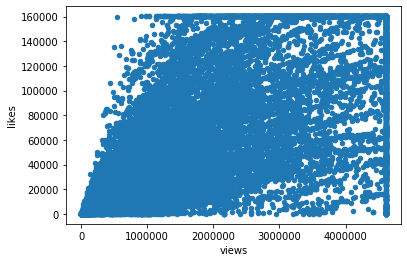

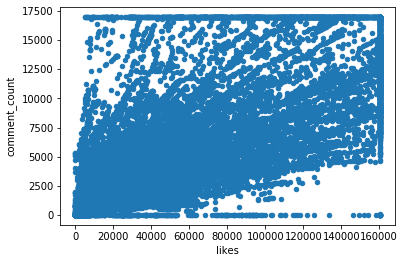

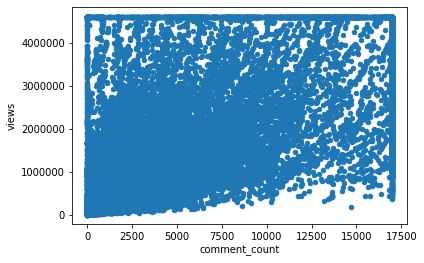

In [27]:
#running some bivariate analysis, it looks like comment counts, likes, and views are all positively 
#correlated
X.plot(kind='scatter', x='views', y='likes')
X.plot(kind='scatter', x='likes', y='comment_count')
X.plot(kind='scatter', x='comment_count', y='views')

In [32]:
#DBSCAN clustering
dbscan_cluster = DBSCAN(eps=1, min_samples=5)

# Fit model
clusters = dbscan_cluster.fit_predict(X_std)

In [35]:
#Assessing DBSCAN
#As can be seen through the Adjusted Random Index Score, DBSCAN is not an appropriate model for
#clustering in this dataset
full_pred = DBSCAN(eps=1, min_samples=5).fit_predict(X_std)

print(pd.crosstab(Y, full_pred))

print(metrics.adjusted_rand_score(Y, full_pred))

col_0           0
category_id      
1            2345
2             384
10           6472
15            920
17           2174
19            402
20            817
22           3210
23           3457
24           9964
25           2487
26           4146
27           1656
28           2401
29             57
43             57
0.0


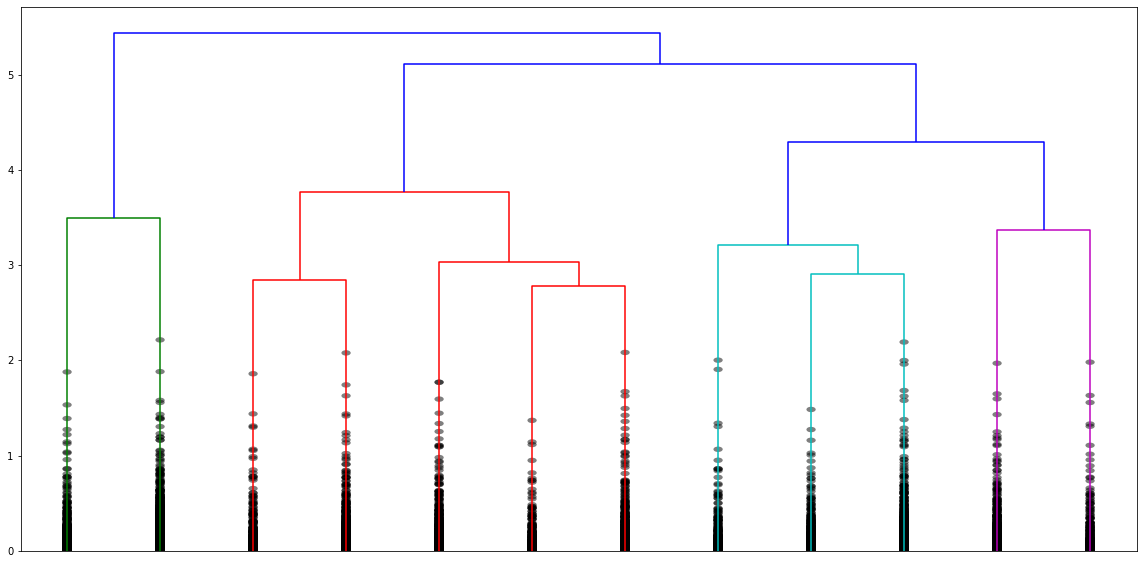

In [13]:
#Heirarchical clustering is also not appropriate for this project since all the different categories
#don't necessarily feed into eachother. Tags would be a different story, but it doesn't fall under 
#the scope of this project

plt.figure(figsize=(20,10))
dendrogram(linkage(X_std, method='complete'), truncate_mode='lastp', p=12,
    show_leaf_counts=False, 
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
)
plt.show()

In [45]:
#GMM Clustering
gmm_cluster = GaussianMixture(n_components=3, random_state=123)

# Fit model
clusters = gmm_cluster.fit(X_std)


In [20]:
full_pred = GaussianMixture(n_components=3, random_state=123).fit_predict(X_std)

print(pd.crosstab(Y, full_pred))
#As can be seen in the Adjusted Random Index Score for The Gaussian Mixture model, it it also not
#good at clustering videos
print(metrics.adjusted_rand_score(Y, full_pred))

col_0           0     1     2
category_id                  
1             879   343  1123
2             235     0   149
10           2079  1881  2512
15            606     5   309
17           1285   159   730
19            244     0   158
20            192   118   507
22           1659   284  1267
23           1378   353  1726
24           4827   627  4510
25           1710     1   776
26           2308   137  1701
27           1101    92   463
28           1311    77  1013
29             48     9     0
43             26     0    31
0.0061587703261578655


<Figure size 720x360 with 0 Axes>

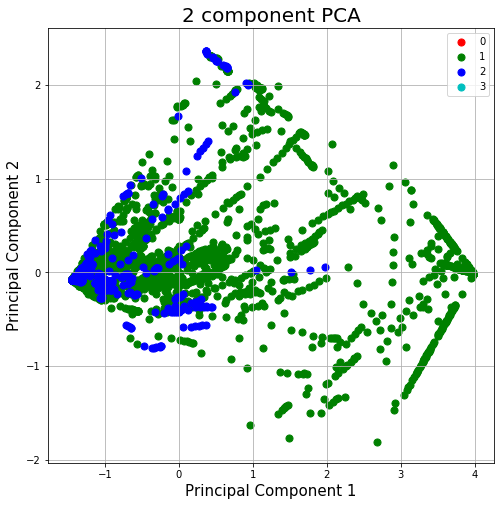

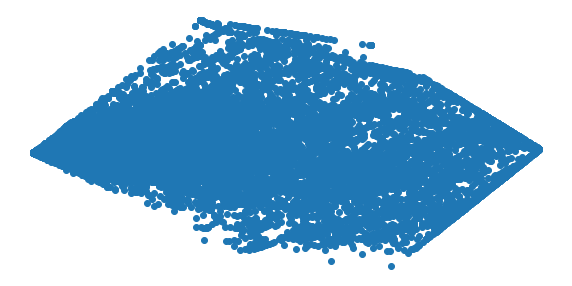

In [47]:
#PCA dimension reduction graphing
#Dimensionality reduction is useful for taking datasets with many features and reducing them down
#to a few. Here I have reduced three features down to two to demonstrate the potential this might
#have at a greater scale

#The eigenvalues can be provided for supervised learning projects
pca = PCA(n_components=2)

pca_components = pca.fit_transform(X_std)
f = plt.figure(figsize=(10,5))
principalDf = pd.DataFrame(data = pca_components, columns = ['principal component 1','principal component 2'])

finalDf = pd.concat([principalDf, Y], axis = 1)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1,2,3]
colors = ['r', 'g', 'b','c']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['category_id'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

plt.figure(figsize=(10,5))
plt.scatter(pca_components[:, 0], pca_components[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [16]:
#TSNE is similar to PCA in that they are both dimensionality reduction techniques

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 40949 samples in 0.047s...
[t-SNE] Computed neighbors for 40949 samples in 1.059s...
[t-SNE] Computed conditional probabilities for sample 1000 / 40949
[t-SNE] Computed conditional probabilities for sample 2000 / 40949
[t-SNE] Computed conditional probabilities for sample 3000 / 40949
[t-SNE] Computed conditional probabilities for sample 4000 / 40949
[t-SNE] Computed conditional probabilities for sample 5000 / 40949
[t-SNE] Computed conditional probabilities for sample 6000 / 40949
[t-SNE] Computed conditional probabilities for sample 7000 / 40949
[t-SNE] Computed conditional probabilities for sample 8000 / 40949
[t-SNE] Computed conditional probabilities for sample 9000 / 40949
[t-SNE] Computed conditional probabilities for sample 10000 / 40949
[t-SNE] Computed conditional probabilities for sample 11000 / 40949
[t-SNE] Computed conditional probabilities for sample 12000 / 40949
[t-SNE] Computed conditional probabilities for sa

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 40949 samples in 0.048s...
[t-SNE] Computed neighbors for 40949 samples in 1.036s...
[t-SNE] Computed conditional probabilities for sample 1000 / 40949
[t-SNE] Computed conditional probabilities for sample 2000 / 40949
[t-SNE] Computed conditional probabilities for sample 3000 / 40949
[t-SNE] Computed conditional probabilities for sample 4000 / 40949
[t-SNE] Computed conditional probabilities for sample 5000 / 40949
[t-SNE] Computed conditional probabilities for sample 6000 / 40949
[t-SNE] Computed conditional probabilities for sample 7000 / 40949
[t-SNE] Computed conditional probabilities for sample 8000 / 40949
[t-SNE] Computed conditional probabilities for sample 9000 / 40949
[t-SNE] Computed conditional probabilities for sample 10000 / 40949
[t-SNE] Computed conditional probabilities for sample 11000 / 40949
[t-SNE] Computed conditional probabilities for sample 12000 / 40949
[t-SNE] Computed conditional probabilities for sa

<Figure size 720x360 with 0 Axes>

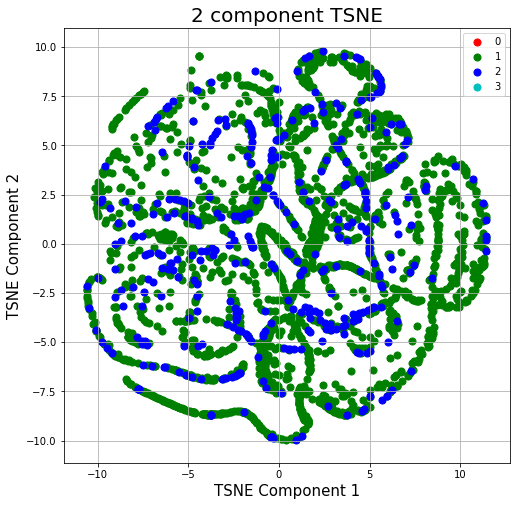

In [29]:
#tSNE graph #1
f = plt.figure(figsize=(10,5))
principalDf = pd.DataFrame(data = tsne_results, columns = ['principal component 1','principal component 2'])

finalDf = pd.concat([principalDf, Y], axis = 1)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('TSNE Component 1', fontsize = 15)
ax.set_ylabel('TSNE Component 2', fontsize = 15)
ax.set_title('2 component TSNE', fontsize = 20)
targets = [0,1,2,3]
colors = ['r', 'g', 'b','c']
for target, color in zip(targets,colors):
    indicesToKeep = Y == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [11]:
#Clustering using UMAP, another dimensionality reduction technique
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X)

C:\Users\mattb\AppData\Local\Continuum\anaconda3\lib\site-packages\umap\rp_tree.py:719: UserWarning: Random Projection forest initialisation failed due to recursionlimit being reached. Something is a little strange with your data, and this may take longer than normal to compute.
  "Random Projection forest initialisation failed due to recursion"
C:\Users\mattb\AppData\Local\Continuum\anaconda3\lib\site-packages\umap\nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\AppData\Local\Continuum\anaconda3\lib\site-packages\umap\utils.py", line 409:
@numba.njit(parallel=True)
def build_candidates(current_graph, n_vertices, n_neighbors, max_candidates, rng_state):
^

  current_graph, n_vertices, n_neighbors, max_candidates, rng_state
C:\Us

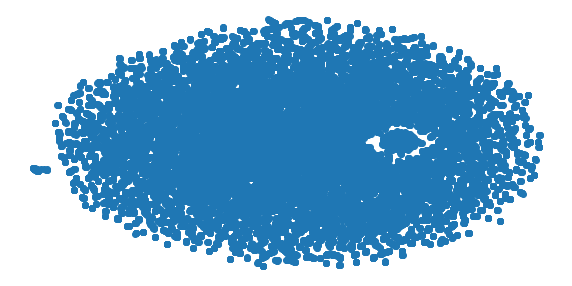

In [12]:
#Graphing UMAP
plt.figure(figsize=(10,5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [14]:
#After exploring dimensionality reduction, i am interested in K-means clustering
#K-means clustering requires data that is normally distributed

#Even winsorized, the data shows significant outliers. Let's try a monotonic
#transformation

views_array = df.views.values.reshape(-1,1) 
df.views = preprocessing.power_transform(views_array, method = 'yeo-johnson')
likes_array = df.likes.values.reshape(-1,1) 
df.likes = preprocessing.power_transform(likes_array, method = 'yeo-johnson')
dislikes_array = df.views.values.reshape(-1,1) 
df.dislikes = preprocessing.power_transform(dislikes_array, method = 'yeo-johnson')
comment_count_array = df.comment_count.values.reshape(-1,1) 
df.comment_count = preprocessing.power_transform(comment_count_array, method = 'yeo-johnson')

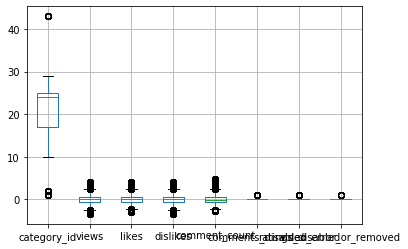

In [72]:
df.boxplot()

In [15]:
#I'm interesting in testing for normality to see if these datasets can be used
#with K-means

p = shapiro(df.views)
print(p)
p = shapiro(df.likes)
print(p)
p = shapiro(df.dislikes)
print(p)
p = shapiro(df.comment_count)
print(p)

(0.9745591878890991, 0.0)
(0.9739203453063965, 0.0)
(0.974096953868866, 0.0)
(0.9731833934783936, 0.0)


C:\Users\mattb\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [48]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

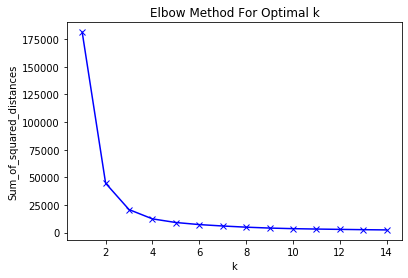

In [49]:
#Here I am plotting to show the ideal number of clusters for k-means

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [50]:
kmeans_cluster = KMeans(n_clusters=3, random_state=123)
kmeans_cluster.fit(X_std)
y_pred = kmeans_cluster.predict(X_std)
data_transformed = kmeans_cluster.transform(X_std)

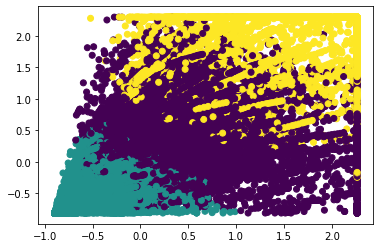

In [51]:
plt.scatter(X_std[:,0], X_std[:,1], c=y_pred)
plt.show()

In [19]:
full_pred = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)

print(pd.crosstab(Y, full_pred))
#As can be seen by the Adjusted Random Index Score, KMeans is only slightly worse than GMM
print(metrics.adjusted_rand_score(Y, full_pred))

col_0           0     1     2
category_id                  
1             623  1229   493
2              90   294     0
10           1387  2802  2283
15            133   753    34
17            297  1665   212
19             63   339     0
20            234   293   290
22            641  2071   498
23            976  1915   566
24           2204  6647  1113
25            270  2195    22
26            889  2941   316
27            135  1396   125
28            445  1737   219
29              0    48     9
43              0    57     0
0.0034377578346022333


# Conclusions

It is hard to create clusters using the features that I included and different categories. It is my assumption from the analytics I've just collected that videos may be successful regardless of their category type.